Resonance frequency vs flux:

\begin{align}
w_r (F) &\approx \frac{w_{\lambda / 4}}{1+\gamma_0 / \left|\cos(F)\right|}\\
w_{\lambda/4} &= w_r (\gamma_0 = 0) \\
\gamma_0 &= L_s^0 / Ll \\
F &= \pi \Phi_{dc} / \Phi_0 \\
\Phi_{dc} &= k_\Phi i_b \\
L_s^0 &= \hbar / (2e I_c)
\end{align}

where $w_{\lambda/4}$ is the bare resonant frequency, $\gamma_0$ is the participation ratio, $ L_s $ is the non-linear Josephson inductance, L is the inductance per unit length and l is the length of the resonator, $ I_c $ is the effective critical current of the SQUID (just 2 times the single junction Ic).


Reference:

\# [1]: Phillip Krantz - Parametrically pumped superconducting circuits

In [44]:
import xarray as xr
import numpy as np
import scipy.constants as cnst
import matplotlib.pyplot as plt
import lmfit

I will use the datasets measured for FJPA-UOT-1910-7G-V1_N5 device.  The first dataset is measured on July 2020 with the sample assembled inside the Aries.  The second dataset is from April 2021 with the Gemini holder.

In [2]:
dsa = xr.open_dataset('data/FJPA-UOT-1910-7G-V1_N5__ARIES.rmap.nc')
dsg = xr.open_dataset('data/FJPA-UOT-1910-7G-V1_N5__GEMINI.rmap.nc')

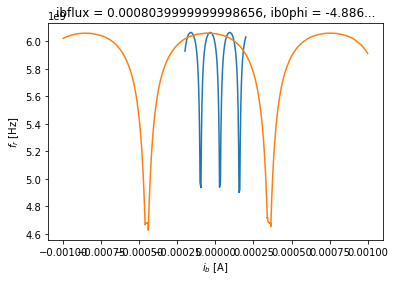

In [4]:
dsa.fr.plot()
dsg.fr.plot()

We can see the x-scale is quite different.  This is mainly due to the number of turns in the biasing coil being much less in the Gemini holder than in the Aries holder.  We can compare the curves with the rough scaling present in the dataset:

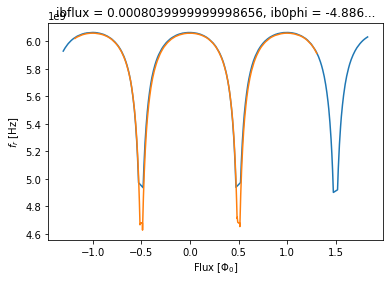

In [5]:
dsa.swap_dims({'ib': 'flux'}).fr.plot()
dsg.swap_dims({'ib': 'flux'}).fr.plot()

Now we see they are quite similar as expected.  The small deviation of the peak point is most likely an estimation error during the ad-hoc scaling of flux.  However, the change in the maximum resonance frequency is definitely a sign of aging on the device.

Let's write down the resonance map function (flux is normalized to flux quantum):

In [7]:
def resmap(flux, gamma_0, w0):
    factor = gamma_0/np.abs(np.cos(np.pi*flux))
    return w0/(1+factor)

Let's just play with this function against the data:

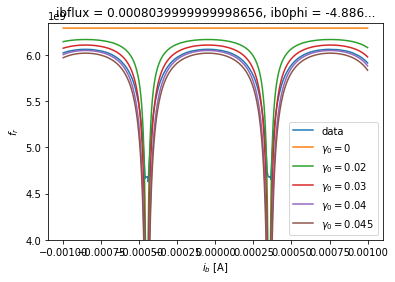

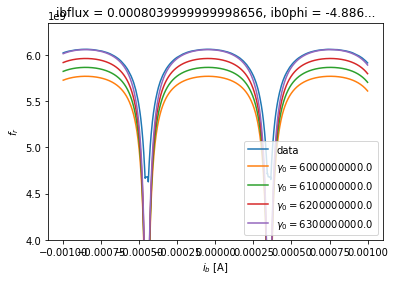

In [81]:
gamma_0 = 0.042
w0 = 6.29e9

fig1, ax = plt.subplots()

dsg.fr.plot(label='data')
for g0 in [0, 0.02, 0.03, 0.04, 0.045]:
    frcalc = resmap(dsg.flux, g0, w0)
    frcalc.plot(label=f'$\gamma_0 ={g0}$')

plt.ylabel('$f_r$')
plt.ylim((4e9, 6.35e9))
plt.legend()


fig2, ax = plt.subplots()

dsg.fr.plot(label='data')
for w0 in [6e9, 6.1e9, 6.2e9, 6.3e9]:
    frcalc = resmap(dsg.flux, 0.04, w0)
    frcalc.plot(label=f'$\gamma_0 ={w0}$')

plt.ylabel('$f_r$')
plt.ylim((4e9, 6.35e9))
plt.legend()

Make a fitting model.

{'gamma_0': 0.029322964491840887, 'w0': 6227357797.953377}


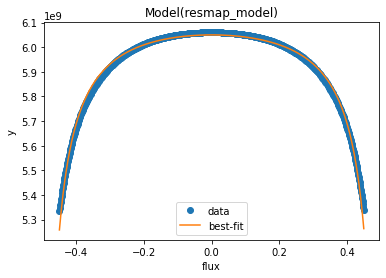

In [142]:
fxw = 0.45
_ds = dsg.where((dsg.flux > -fxw)&(dsg.flux < fxw)).dropna(dim='ib', how='all')

@lmfit.Model
def resmap_model(flux, gamma_0=0.05, w0=6.3e9):
    return resmap(flux, gamma_0, w0)

resmap_model.set_param_hint('gamma_0', value=0.2)
resmap_model.set_param_hint('w0', value=6.3e9)

fit = resmap_model.fit(
    flux=_ds.flux.values,
    data=_ds.fr.values,
    nan_policy='omit', method='nelder')
fit.plot_fit()
print(fit.best_values)

g0 = 0.08
w0 = 6.7e9
frcalc = resmap(_ds.flux, g0, w0)
#frcalc.swap_dims({'ib': 'flux'}).plot(label=f'$\gamma_0 ={w0}$')

In [98]:
_ds

<xarray.Dataset>
Dimensions:  (ib: 2001)
Coordinates:
    flux     (ib) float64 -1.183 -1.182 -1.181 -1.179 ... 1.302 1.303 1.305
  * ib       (ib) float64 -0.001 -0.000999 -0.000998 ... 0.000998 0.000999 0.001
    ibflux   float64 0.000804
    ib0phi   float64 -4.887e-05
Data variables:
    fr       (ib) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan